In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
# with tf.device('/gpu:0'):

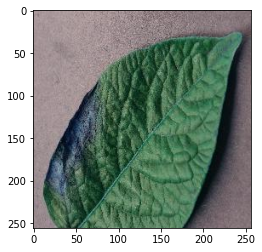

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from skimage.color import rgb2gray
%matplotlib inline
from scipy import ndimage

DATADIR = "/content/drive/My Drive/PlantVillage/tomato_dataset"

CATEGORIES = ["Potato___Late_blight", "Potato_Early_blight", "Potato_healthy", "Pepper__bell___healthy",
              "Pepper__bell___Bacterial_spot","Tomato__Target_Spot","Tomato__Tomato_mosaic_virus",
              "Tomato__Tomato_YellowLeaf__Curl_Virus","Tomato_Bacterial_spot","Tomato_Early_blight",
              "Tomato_healthy", "Tomato_Late_blight","Tomato_Leaf_Mold","Tomato_Septoria_leaf_spot", 
              "Tomato_Spider_mites_Two_spotted_spider_mite"]

for category in CATEGORIES:  
    path = os.path.join(DATADIR,category)  # create path 
    for img in os.listdir(path):  # iterate over each image 
        img_array = cv2.imread(os.path.join(path,img) )  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  
    break  

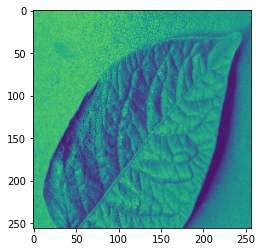

In [6]:
imagex = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
gray = rgb2gray(imagex)
plt.imshow(gray)

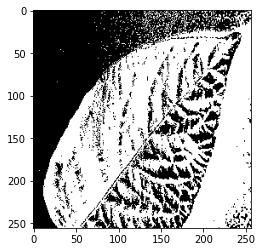

In [7]:
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > np.amax(gray_r)*0.47:
    #if gray_r[i] > gray_r.mean():
        gray_r[i] = 0
    else:
        gray_r[i] = 1
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

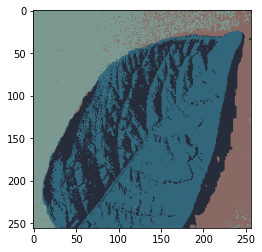

In [8]:
image = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
#image = img_array
HLS_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2HLS)
r,g,b = cv2.split(image)
h,l,s = cv2.split(HLS_img)
image = cv2.merge((h,l,g,))

image = image.reshape((-1,3))


image = np.float32(image)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
K = 4
ret,label,center=cv2.kmeans(image,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)


center = np.uint8(center)
res = center[label.flatten()]

res2 = res.reshape((img_array.shape))



plt.imshow(res2)

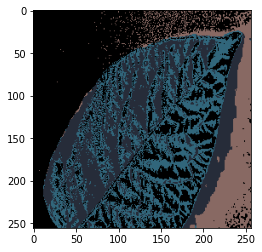

In [9]:
new_img = np.zeros(res2.shape, dtype='uint8')
for i in [0,1,2]:
    new_img[:,:,i] = res2[:,:,i]*gray
    plt.imshow(new_img)

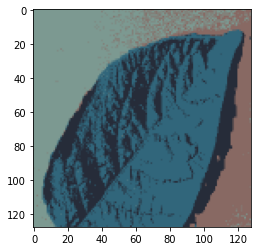

In [10]:
IMG_LONG = 128
IMG_LARGE = 128

new_array = cv2.resize(res2, (IMG_LONG, IMG_LARGE))
plt.imshow(new_array, cmap='gray')
#plt.show()

In [11]:
training_data = []
with tf.device('/gpu:0'):
      
    def create_training_data():
        for category in CATEGORIES:  # do 

            path = os.path.join(DATADIR,category)  # create path
            class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 

            for img in tqdm(os.listdir(path)):  # iterate over each image 
                try:
                    img_array = cv2.imread(os.path.join(path,img))  # convert to array ->  ,cv2.IMREAD_GRAYSCALE for grayscaling

                    new_img = img_array
                    new_img = cv2.resize(new_img, (IMG_LARGE, IMG_LONG))
                    #new_img = cv2.rotate(new_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    
                    training_data.append([new_img, class_num])  # add this to our training_data
                except Exception as e:  # in the interest in keeping the output clean...
                    pass
    create_training_data()

print(len(training_data))

 47%|████▋     | 469/997 [01:59<02:16,  3.86it/s]

KeyboardInterrupt: ignored

In [14]:
print(len(training_data))

1915


In [15]:
import random

random.shuffle(training_data)
for sample in training_data[:20]:
    print(sample[1])

0
0
1
1
0
0
1
0
1
1


In [16]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_LONG, IMG_LARGE, 3)
print(X.shape)

(1915, 128, 128, 3)


In [17]:
y = np.array(y)
print(len(y))

1915


In [18]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [23]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import pickle

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0
with tf.device('/gpu:0'):
    model = Sequential()

    model.add(Conv2D(16, (3, 3), input_shape=X.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

    model.add(Dense(64))
    model.add(Activation('relu'))

    model.add(Dense(15))
    model.add(Activation('softmax'))

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer='adam',
                metrics=['accuracy']
                )

    model.fit(X, y, batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
48/48 [==============================] - 1s 19ms/step - loss: 0.7874 - accuracy: 0.6369 - val_loss: 0.4113 - val_accuracy: 0.8564
Epoch 2/50
48/48 [==============================] - 1s 14ms/step - loss: 0.3983 - accuracy: 0.8699 - val_loss: 0.3506 - val_accuracy: 0.8721
Epoch 3/50
48/48 [==============================] - 1s 14ms/step - loss: 0.3071 - accuracy: 0.8850 - val_loss: 0.3187 - val_accuracy: 0.8747
Epoch 4/50
48/48 [==============================] - 1s 14ms/step - loss: 0.2746 - accuracy: 0.8962 - val_loss: 0.3642 - val_accuracy: 0.8590
Epoch 5/50
48/48 [==============================] - 1s 14ms/step - loss: 0.2507 - accuracy: 0.8966 - val_loss: 0.2687 - val_accuracy: 0.8956
Epoch 6/50
48/48 [==============================] - 1s 14ms/step - loss: 0.2257 - accuracy: 0.9023 - val_loss: 0.2236 - val_accuracy: 0.9138
Epoch 7/50
48/48 [==============================] - 1s 14ms/step - loss: 0.1793 - accuracy: 0.9420 - val_loss: 0.2412 - val_accuracy: 0.9164
Epoch 8/50
48

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13362114854448707959, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3510621208411801091
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17333704806222626946
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14613293312
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3549960315528059909
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.3.0
Running on TPU  ['10.126.23.34:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.126.23.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.126.23.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
